In [1]:
#This code compares different R2 and run time results for different 
#moving average window widths

from sklearn.datasets import fetch_openml
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import sklearn.linear_model as skl_lm
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score

from sklearn.model_selection import train_test_split, LeaveOneOut, KFold, cross_val_score
from sklearn.preprocessing import PolynomialFeatures

from sklearn import utils
from sklearn import preprocessing
from sklearn import neighbors
from pandas import read_csv

from sklearn.feature_selection import SelectKBest, f_classif

from sklearn import preprocessing

from sklearn.feature_selection import SelectKBest

from copy import deepcopy

import csv
lda = LinearDiscriminantAnalysis()
qda = QuadraticDiscriminantAnalysis()
kfld = KFold(n_splits=3,random_state=42)

In [2]:
#Reads data in from data folder.

data = read_csv('data/ethylene_methane.txt',delim_whitespace=True)
print(data.shape)

(4178504, 19)


In [3]:
#creates a new attribute thats the % Methane, in cases where we divide by zero
#we recieve a NAN which is replaced by a 0
#the 4th line drops that attributes that we defined to be unnecasry from our K
#best select we ran in a previous part of our code
#this code also finds all unique PPM for methane

data['Methane%'] = (data['Methane(ppm)']/(data['Methane(ppm)']+data['Ethylene(ppm)']))
data['Methane%'] = data['Methane%'].fillna(0)

ppm = data['Methane(ppm)'].unique()

data = data.drop(columns = ['Time(sec)', 'sensor1', 'sensor2','sensor9','sensor10'])

sensor_name = ['sensor3', 'sensor4', 'sensor5','sensor6', 'sensor7', 'sensor8', 'sensor11','sensor12', 'sensor13', 'sensor14', 'sensor15', 'sensor16']


In [4]:
#This block searches for Outliers for each PPM of Methane and then drops them
#from the file.

for j in sensor_name:
    print(j)
    for i in np.sort(ppm):    
        data2 = data[data["Methane(ppm)"] == i] #only select a specific PPM to begin trimming
        
        results = data2[j].quantile([0.125,0.875]) #Next lines calculate the range for non-Outliers
        IQR_15 = 1.5*(results.loc[0.875] - results.loc[0.125])
        fq = results.loc[0.125] - IQR_15
        tq = results.loc[0.875] + IQR_15
                
        index = data2[(fq>data2[j]) | (tq<data2[j])] #Finds Outliers
        data = data.drop(index.index) #Uses index of Outliers to drop rows from data 
      

sensor3
sensor4
sensor5
sensor6
sensor7
sensor8
sensor11
sensor12
sensor13
sensor14
sensor15
sensor16


In [11]:
data.head()

,Methane(ppm),Ethylene(ppm),sensor3,sensor4,sensor5,sensor6,sensor7,sensor8,sensor11,sensor12,sensor13,sensor14,sensor15,sensor16,Methane%
3579,0.0,0.0,3407.506286,3754.603143,2150.950000,2707.213905,2697.069238,2915.878571,2665.986286,2516.178286,2019.833524,2267.264190,2242.542000,1880.299333,0.0
3580,0.0,0.0,3405.911333,3753.634286,2150.210381,2705.921143,2696.559714,2915.123810,2665.456000,2515.648286,2019.300190,2266.893619,2241.642381,1879.664476,0.0
3581,0.0,0.0,3404.693048,3752.733810,2149.470857,2704.982190,2695.917429,2914.589048,2665.032952,2515.303143,2018.688667,2266.243619,2240.668857,1878.817714,0.0
3582,0.0,0.0,3403.985143,3751.868952,2148.827429,2704.103429,2695.382571,2913.979429,2664.316952,2514.931333,2018.334667,2265.623905,2239.723429,1878.178857,0.0
3583,0.0,0.0,3403.466952,3751.203714,2148.138667,2703.397429,2694.772952,2913.137238,2663.720286,2514.564857,2017.884571,2264.906286,2238.719810,1877.380571,0.0


In [13]:
#this block of code test the results for moving averages 5,7,9,11,13,15. It uses deepcopy to create a copy of the data
#to constantly refer back too at the start of a new average test
df = deepcopy(data)
scores = list()
times = list()
avg = [5,6,7,8,9,10,11,12,13,14,15]


for m in avg:
    print(m)
    print(df.shape)
    data = deepcopy(df)
    print(data.shape)
    for k in sensor_name: #change df back to data
        data[k]=df[k].rolling(window=m).mean() #rolling has the the window starting at the right edge by default
        
    data = data.dropna()
    
    X = data.drop(columns = ['Methane(ppm)','Ethylene(ppm)','Methane%'])
    y = np.where(data['Methane%'] >= 0.5, 1, 0)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.50, random_state=42)  
    print('CV')
    start = time.time()
    clf = LogisticRegression(random_state=42, solver='lbfgs',max_iter=10000,n_jobs = -1).fit(X_train, y_train)
    score = cross_val_score(clf, X_test, y_test, cv=kfld, scoring='r2').mean()
    end = time.time()
    print(data.shape)
    print(end-start)
    print("")
    scores.append(score)
    times.append((end-start))

5
(3926717, 15)
(3926717, 15)
CV
(3926713, 15)
258.37213706970215

6
(3926717, 15)
(3926717, 15)
CV
(3926712, 15)
323.99923491477966

7
(3926717, 15)
(3926717, 15)
CV
(3926711, 15)
264.32201862335205

8
(3926717, 15)
(3926717, 15)
CV
(3926710, 15)
246.04694724082947

9
(3926717, 15)
(3926717, 15)
CV
(3926709, 15)
268.4989159107208

10
(3926717, 15)
(3926717, 15)
CV
(3926708, 15)
291.51777148246765

11
(3926717, 15)
(3926717, 15)
CV
(3926707, 15)
215.6368124485016

12
(3926717, 15)
(3926717, 15)
CV
(3926706, 15)
251.42633605003357

13
(3926717, 15)
(3926717, 15)
CV
(3926705, 15)
271.80584383010864

14
(3926717, 15)
(3926717, 15)
CV
(3926704, 15)
263.026903629303

15
(3926717, 15)
(3926717, 15)
CV
(3926703, 15)
276.82688212394714



Text(0, 0.5, 'R2')

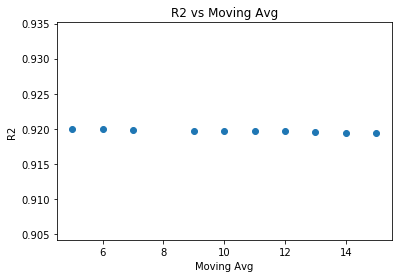

In [10]:
#Plots the R2 vs the Moving avg # value calculated in the previou block


#plt.ylim(0.90, 0.93) 
plt.scatter(avg,scores)
plt.title("R2 vs Moving Avg")
plt.xlabel("Moving Avg")
plt.ylabel("R2")

Text(0, 0.5, 'Time (sec)')

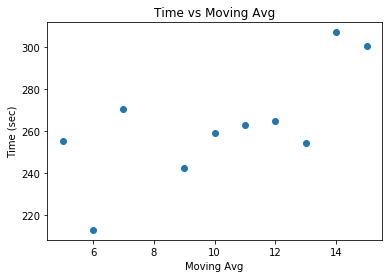

In [9]:
#Plots the Run time vs the Moving avg # value calculated in the previou block
plt.scatter(avg,times)
plt.title("Time vs Moving Avg")
plt.xlabel("Moving Avg")
plt.ylabel("Time (sec)")